### Import the required packages

In [1]:
#import basic packages
import os, json
import pandas as pd
import numpy as np

#import geospatial packages
import rasterio
import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiLineString, MultiPoint

#plots
import matplotlib.pyplot as plt

#modflow
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf

#link path to src folder
import sys
sys.path.insert(0, '../src')
from meshProperties import mesh_shape
from geoVoronoi import createVoronoi

### Define mesh

Build mesh from geospatial data with a given src.

In [2]:
#Create mesh object
vorMesh = createVoronoi()

#Define base refinement and refinement levels
vorMesh.defineParameters(maxRef = 80, minRef=10, stages=5)


/--------Sumary of cell discretization-------/
Maximun refinement: 80.00 m.
Minimum refinement: 10.00 m.
Cell size list: [80.  62.5 45.  27.5 10. ] m.
/--------------------------------------------/



In [3]:
#Open limit layers and refinement definition layers
vorMesh.addLimit('basin','../inputData/River_and_wells/shp/ModelLimit1.shp')
vorMesh.addLayer('wells','../inputData/River_and_wells/shp/ModelWell2.shp')
vorMesh.addLayer('river','../inputData/River_and_wells/shp/ModelRiver2.shp')

In [4]:
#Generate point pair array
vorMesh.extractOrgVertices()

#Generate the point cloud and voronoi
vorMesh.createPointCloud()
vorMesh.generateVoronoi()

#check or create an output folder
outPath = '../outputData/River_and_wells'
if os.path.isdir(outPath):
    print('The output folder %s exists'%outPath)
else:
    os.mkdir(outPath)
    print('The output folder %s has been generated.'%outPath)

#Export point data and voronoi polygons
#Points
vorMesh.getPointsAsShp('vertexOrg',outPath+'/vertexOrg.shp')
vorMesh.getPointsAsShp('vertexDist',outPath+'/vertexDist.shp')
vorMesh.getPointsAsShp('vertexBuffer',outPath+'/vertexBuffer.shp')
vorMesh.getPointsAsShp('vertexMaxRef',outPath+'/vertexMaxRef.shp')
vorMesh.getPointsAsShp('vertexMinRef',outPath+'/vertexMinRef.shp')
vorMesh.getPointsAsShp('vertexTotal',outPath+'/vertexTotal.shp')
#Polygons

vorMesh.getPolyAsShp('voronoiRegions',outPath+'/voronoiRegions.shp')


/----Sumary of points for voronoi meshing----/
Distributed points from layers: 680
Points from layer buffers: 1360
Points from max refinement areas: 749
Points from min refinement areas: 1335
Total points inside the limit: 4090
/--------------------------------------------/

Time required for point generation: 2.37 seconds 

The output folder ../outputData/River_and_wells exists


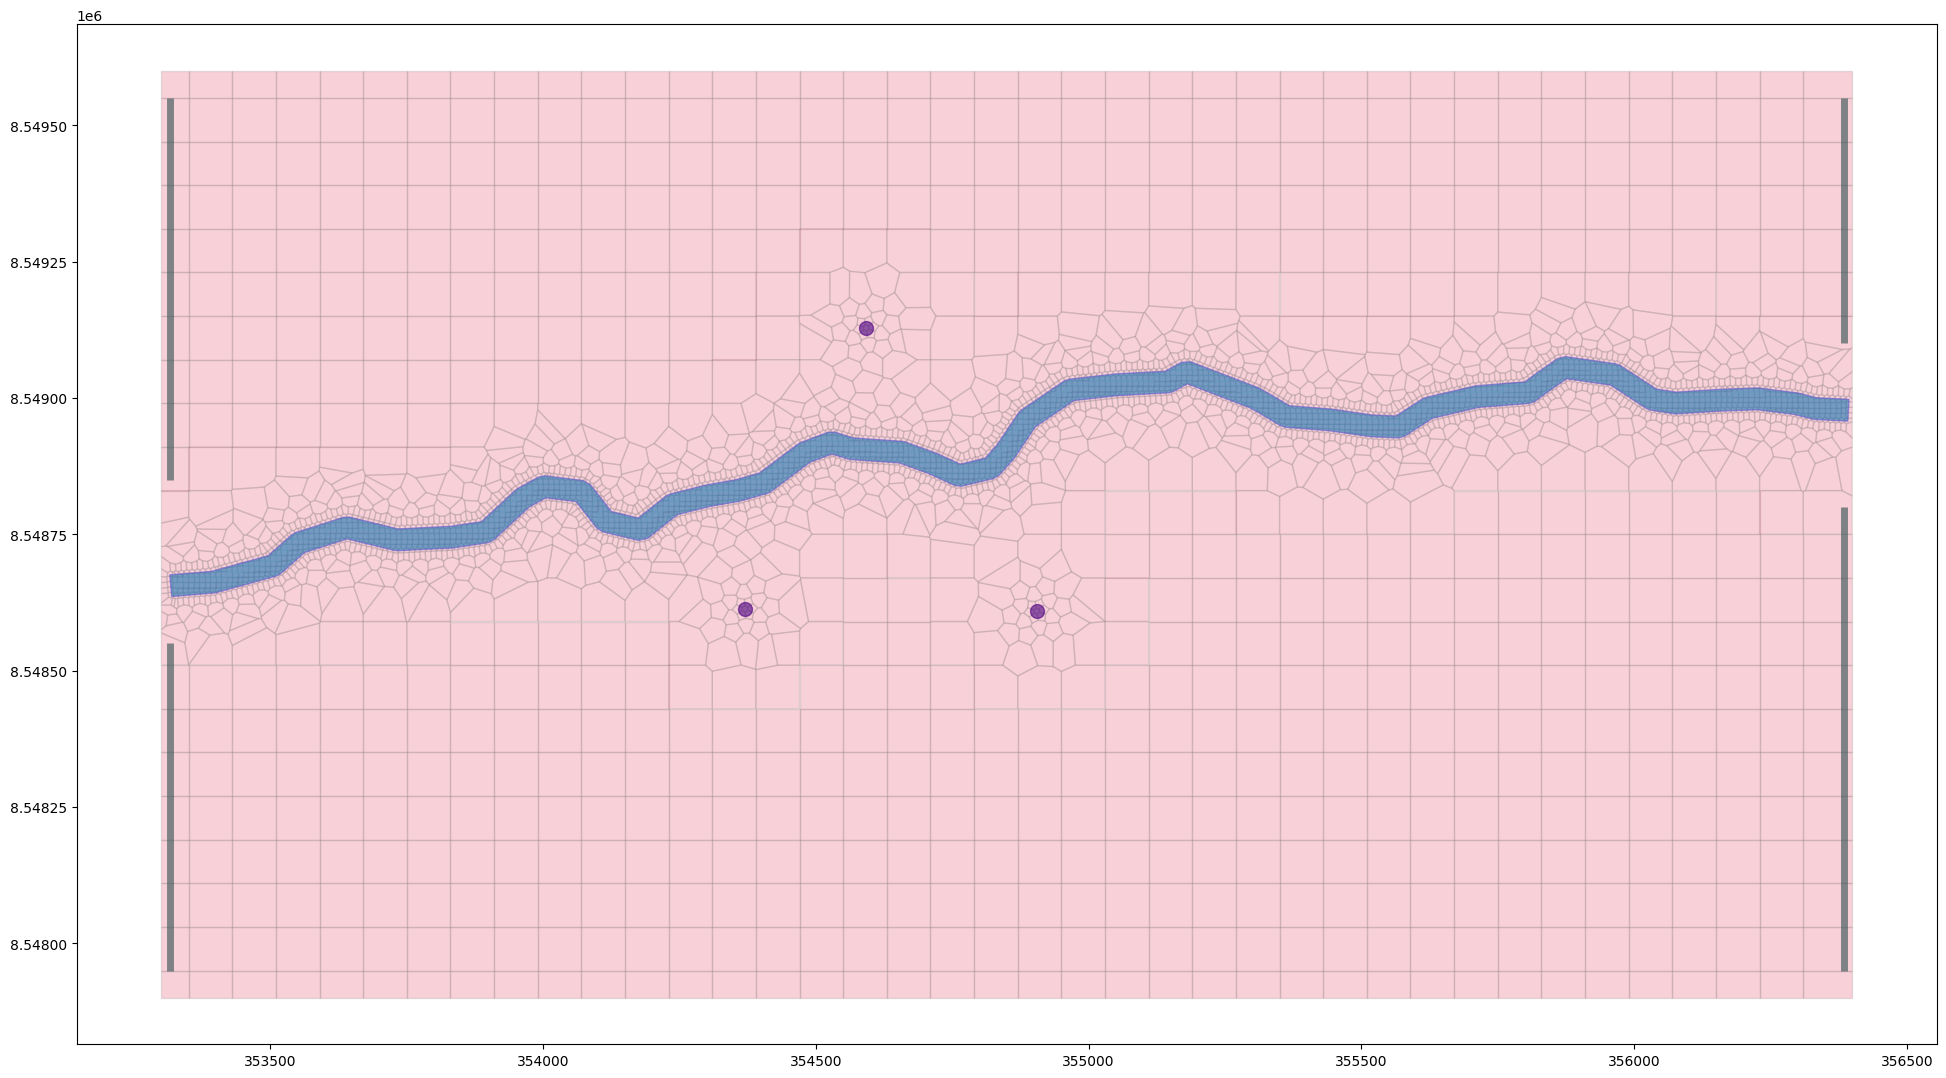

In [5]:
# plot geospatial data with geopandas
import warnings
warnings.filterwarnings('ignore')

voronoiMesh = gpd.read_file('../outputData/River_and_wells/voronoiRegions.shp')
modelRiver = gpd.read_file('../inputData/River_and_wells/shp/ModelRiver2.shp')
modelGhb = gpd.read_file('../inputData/River_and_wells/shp/ModelGHB1.shp')
modelWell = gpd.read_file('../inputData/River_and_wells/shp/ModelWell2.shp')

fig, ax = plt.subplots(figsize=(24,18))
voronoiMesh.plot(ax=ax, alpha=0.2, ec='grey', fc='crimson')
modelRiver.plot(ax=ax, alpha=0.6, ec='slateblue')
modelGhb.plot(ax=ax, alpha=0.6, ec='darkslategrey', lw=5)
modelWell.plot(ax=ax, alpha=0.6, fc='indigo',markersize=100)
plt.show()

### Generation of the Voronoi grid

In [6]:
# get the mesh data from the shapefile
mesh=mesh_shape('../outputData/River_and_wells/voronoiRegions.shp')
gridprops=mesh.get_gridprops_disv()


Creating a unique list of vertices [[x1,y1],[x2,y2],...]


100%|██████████| 4090/4090 [00:00<00:00, 17800.58it/s]



Extracting cell2d data and grid index


100%|██████████| 4090/4090 [00:00<00:00, 4387.60it/s]


In [7]:
#define the disv list of vertices and cells
cell2d = gridprops['cell2d']
vertices = gridprops['vertices']
ncpl = gridprops['ncpl']
nvert = gridprops['nvert']
centroids=gridprops['centroids']

In [8]:
#sample of the cell2d items
cell2d[:5]

[[0, 353305.0842893986, 8548677.699736858, 6, 35, 17, 18, 41, 38, 35],
 [1, 353314.9830338129, 8548668.095507141, 7, 35, 38, 54, 56, 50, 37, 35],
 [2, 353304.6801875851, 8548592.884968264, 5, 42, 34, 10, 11, 42],
 [3, 353325.0, 8547990.0, 5, 109, 108, 1, 2, 109],
 [4, 353305.0450244283, 8548666.712527014, 6, 35, 37, 36, 16, 17, 35]]

### Define aquifer geometry

In [9]:
#Extract dem values for each centroid of the voronois
src = rasterio.open('../inputData/River_and_wells/rst/ModeloDem1Filled.tif')
elevation=[x for x in src.sample(centroids)]

#number of lays
nlay = 3

#define mtop
mtop=np.array([elev[0] for i,elev in enumerate(elevation)])

#define zbot
zbot=np.zeros((nlay,ncpl))

AcuifInf_Bottom = -120
AcuifMed_Bottom = AcuifInf_Bottom + (0.5 * (mtop - AcuifInf_Bottom))
AcuifSup_Bottom = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom))

zbot[0,] = AcuifSup_Bottom 
zbot[1,] = AcuifMed_Bottom
zbot[2,] = AcuifInf_Bottom

### Define a MODFLOW 6 simulation and model

In [10]:
# create simulation
model_name = 'geo_model'
model_ws = '../outputData/River_and_wells/model'
exe_name = '../modflowExe/mf6.exe'

sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name,sim_ws=model_ws)

In [11]:
# create temporal discretization package - tdis
nper = 11
tdis_rc = [(1.0,1,1.0)] + [(200 * 86400.0, 4, 1.0) for a in range(nper -1)]

tdis=flopy.mf6.ModflowTdis(sim, nper=nper, time_units='seconds',perioddata=tdis_rc)

In [12]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='BICGSTAB')

In [13]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True, newtonoptions=['under_relaxation'])

In [14]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,top=mtop, botm=zbot,nvert=nvert, vertices=vertices,cell2d=cell2d)

In [15]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)]))

### Define steady and transient parameters

In [16]:
Kx =[1E-5,5E-4,2E-4]
icelltype = [1,1,0]
npf = flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=icelltype,k=Kx)

In [17]:
sto=flopy.mf6.ModflowGwfsto(gwf,ss=1e-05, sy=0.15)

### Plot grid from flopy utilities

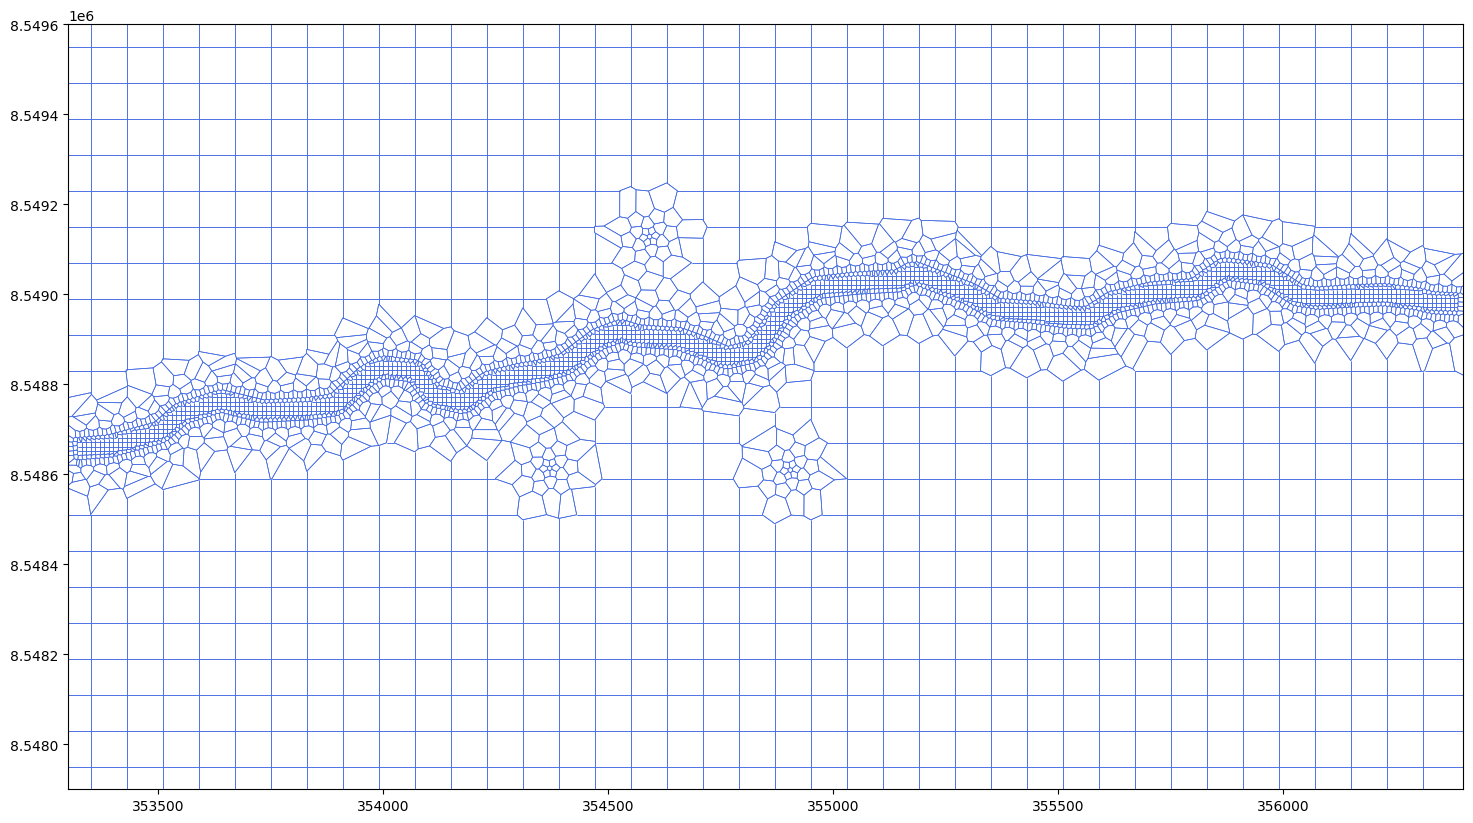

In [18]:
#map view
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='royalblue')

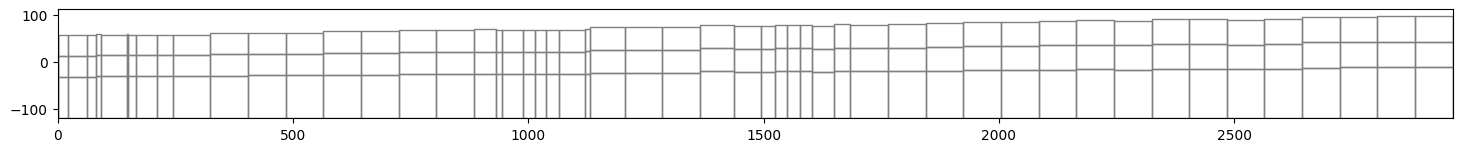

In [19]:
#plot cross section
line = np.array([(353304.219,8548577.580), (356374.790,8548586.576)])

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
linecollection = modelxsect.plot_grid()

### Evapotranspiration package

In [20]:
#evapotranspiration package
evtr = 1.2/365/86400
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0)

### Recharge package

In [21]:
#define a grid intersect object
tgr = fgrid.VertexGrid(vertices, cell2d)
ix2 = GridIntersect(tgr)

In [22]:
#find cells inside a polygon shapefile
zone1=gpd.read_file('../inputData/River_and_wells/shp/ModelRechargeZone1.shp')
result=ix2.intersect(zone1['geometry'].loc[0])

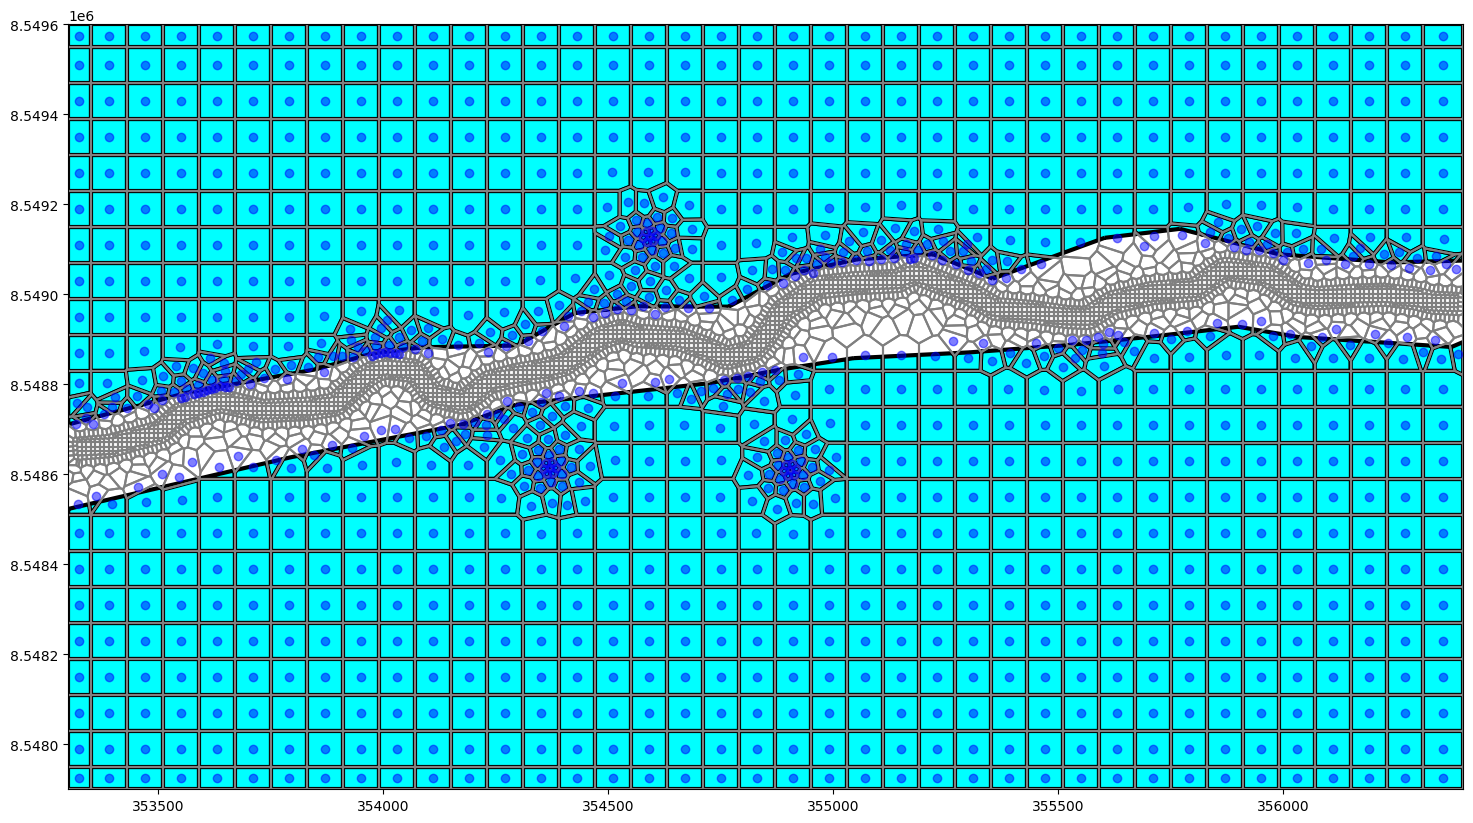

In [23]:
#plot intersected cells
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_polygon(result, ax=ax, fc='aqua', lw=3)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "bo",
        alpha=0.5)

In [24]:
#apply recharge on selected cells
rchr = 0.2/365/86400
rchr_list = []
for i in result.cellids:
    rchr_list.append([0,i,rchr])
rchr_spd = {0:rchr_list}

In [25]:
#recharge package
rch = flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rchr_spd)

### Well package

In [26]:
#read well shapefile
well_zone=gpd.read_file('../inputData/River_and_wells/shp/ModelWell2.shp')

#create list of well positions
list_wells=[]
for i in range(well_zone.shape[0]): 
    list_wells.append(well_zone['geometry'].loc[i])

#define multipoint geometry and intersect
mp = MultiPoint(points=list_wells)
result=ix2.intersect(mp)

#define pumping and apply to cells
pump = -0.15
well_list = []
for i in result.cellids:
    well_list.append([1,i,pump])
well_spd = {1:well_list}

#apply well package
well=flopy.mf6.ModflowGwfwel(gwf,stress_period_data=well_spd)

### River package - RIV

In [27]:
#open river shapefile
river_zone=gpd.read_file('../inputData/River_and_wells/shp/ModelRiver2.shp')

#intersect river geometry
result=ix2.intersect(river_zone['geometry'].loc[0])

#apply parameters to intersect cells
river_list = []
for i in result.cellids:
    river_list.append([0,i,mtop[i],0.01,mtop[i]-1])
river_spd = {0:river_list}

#create river package
river=flopy.mf6.ModflowGwfriv(gwf,stress_period_data=river_spd)

### Regional flow as General Head Boundary - GHB

In [28]:
#open GHB file
boundaries_zone=gpd.read_file('../inputData/River_and_wells/shp/ModelGHB1.shp')

#create list of geometries
list_boundaries=[]
for i in range(boundaries_zone.shape[0]):   
    list_boundaries.append(boundaries_zone['geometry'].loc[i])
    
#create multiline
mls = MultiLineString(lines=list_boundaries)

#intersect rivers with our grid
result=ix2.intersect(mls)

#define cell as ghb
#[cellid, bhead, cond, aux, boundname]
ghb_list=[]

for idx in result.cellids:
    point=centroids[idx]
    if point[0]<354500:
         ghb_list.append([0,i,55,0.01])
    else:
         ghb_list.append([0,i,90,0.01])
ghb_spd={0:ghb_list}

#define ghb package
ghb=flopy.mf6.ModflowGwfghb(gwf,stress_period_data=ghb_spd)

### Define output and run simulation

In [29]:
hname = '{}.hds'.format(model_name)
cname = '{}.cbc'.format(model_name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
 head_filerecord=hname,
 saverecord=[('HEAD', 'ALL'), ('BUDGET',
'ALL')])

In [30]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model geo_model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package evta_0...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 1142 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 3 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 2012 based on size of stress_period_data
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 34 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\modflowExe\mf6.exe
                     

(True, [])

### Plot model output

In [31]:
#open head file
hds = bf.HeadFile(model_ws+'/'+model_name + '.hds')
head = hds.get_data(totim=hds.get_times()[-1])
head[head==1e+30]=np.nan

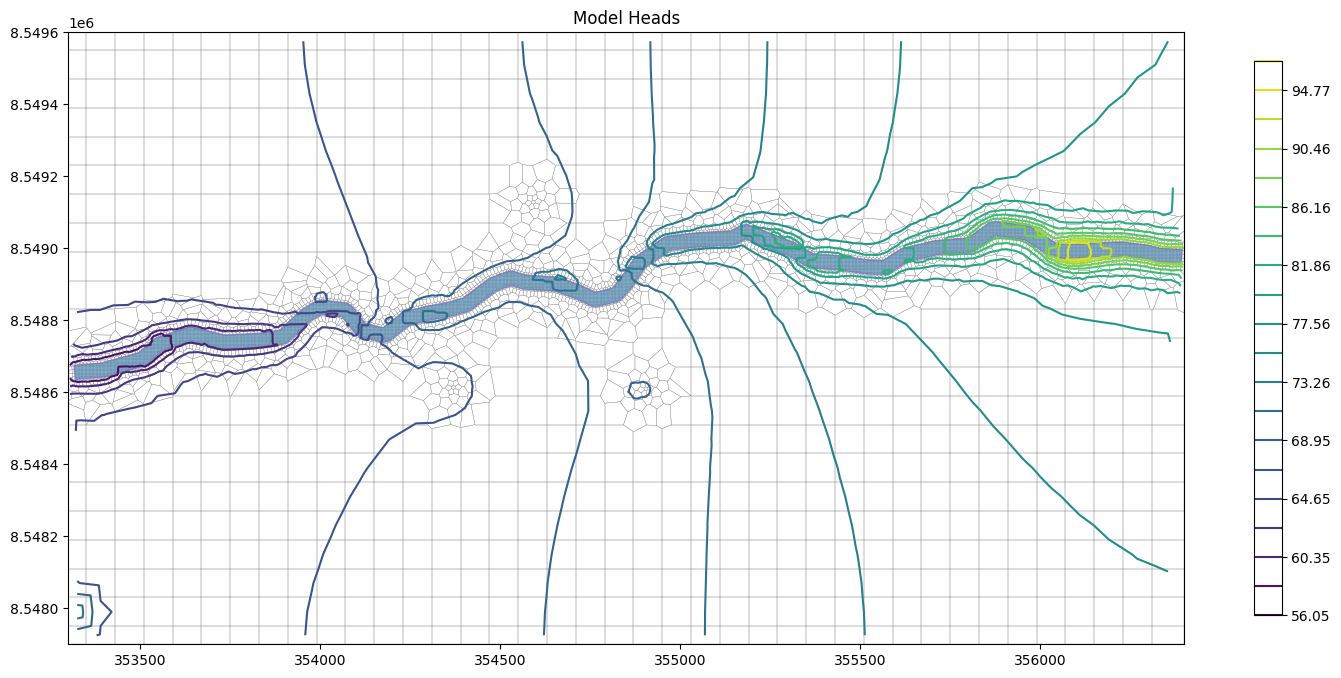

In [32]:
#plot model heads
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)
modelRiver.plot(ax=ax, alpha=0.6, ec='slateblue')
linecollection = mapview.plot_grid(lw=0.2)

levels = np.linspace(np.nanmin(head),np.nanmax(head),num=20)
contour_set = mapview.contour_array(head,levels=levels)
t = ax.set_title("Model Heads")
plt.colorbar(contour_set, shrink=0.6)
plt.show()

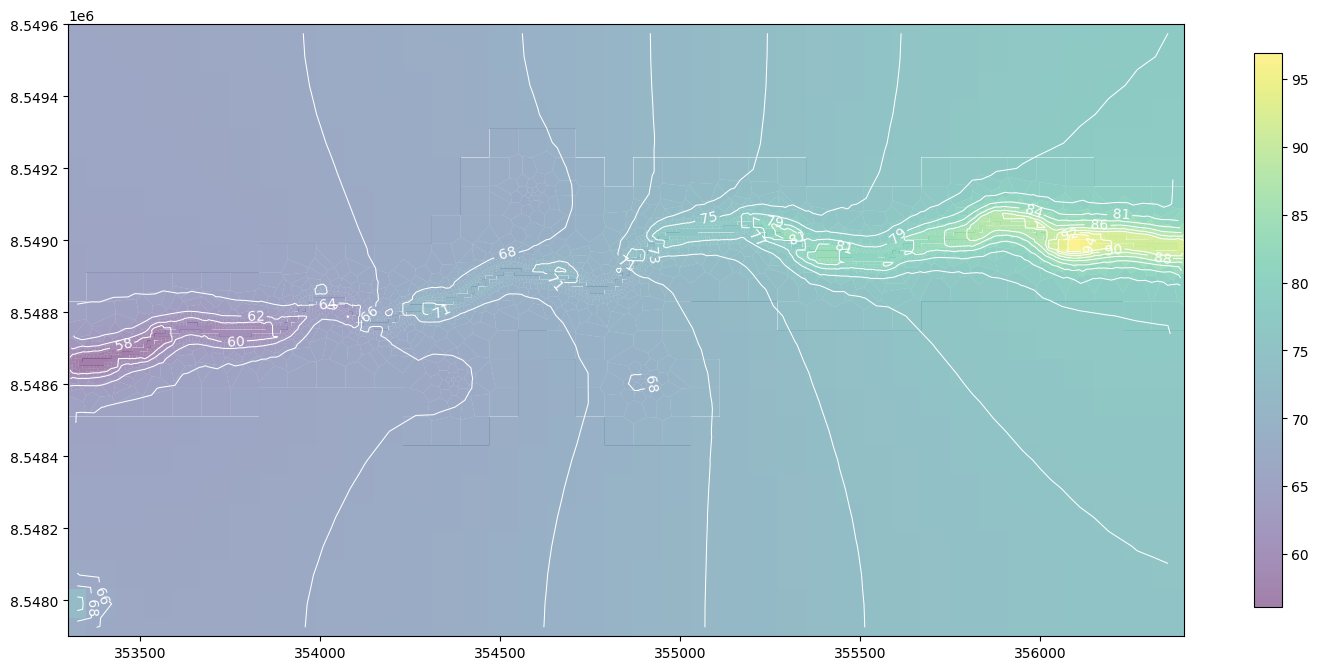

In [33]:
#plot model heads with colorgrid and label contours
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)

quadmesh = mapview.plot_array(head, alpha=0.5)
levels = np.linspace(np.nanmin(head),np.nanmax(head),num=20)
c = mapview.contour_array(head, linewidths=0.75,colors='white',levels=levels)
plt.clabel(c, fmt='%3d')
plt.colorbar(quadmesh, shrink=0.6)
plt.show()

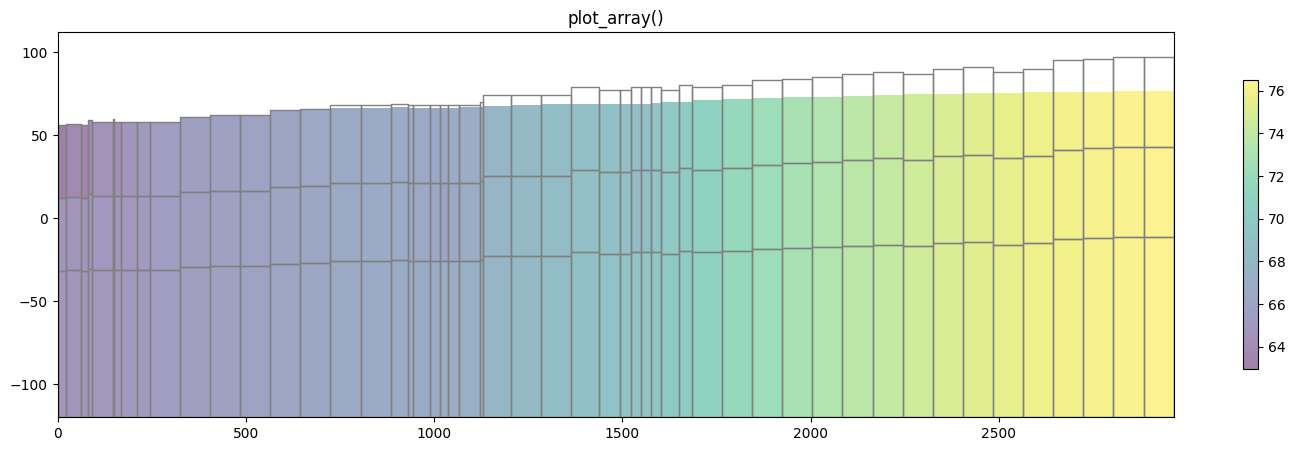

In [34]:
#plot cross section
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array()")

xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
patch_collection = xsect.plot_array(head, head=head, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

In [35]:
#Idea for VTK Viewer within 
#https://docs.pyvista.org/api/readers/_autosummary/pyvista.vtkdatasetreader#pyvista.VTKDataSetReader